In [2]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import os

import torch.nn.functional as F
import pickle
from ast import List
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, random_split

from privacy_meter.audit import Audit, MetricEnum
from privacy_meter.metric import PopulationMetric
from privacy_meter.information_source_signal import ModelGradientNorm, ModelGradient, ModelLoss
from privacy_meter.hypothesis_test import linear_itp_threshold_func
from privacy_meter.audit_report import ROCCurveReport, SignalHistogramReport
from privacy_meter.constants import InferenceGame
from privacy_meter.dataset import Dataset
from privacy_meter.information_source import InformationSource
from privacy_meter.model import PytorchModelTensor

from privacy_meter import audit_report

### Set up the environment

#### Prepare dataset

In [3]:
# Load features and labels
with open('../Dataset/dataset_texas/texas/100/feats', 'r') as f:
    features = f.readlines()
with open('../Dataset/dataset_texas/texas/100/labels', 'r') as f:
    labels = f.readlines()

In [4]:
# Example features and labels list
features_list = [list(map(int, ''.join(feature.split()).split(','))) for feature in features]
labels_list = [int(label.strip()) for label in labels]

# Convert lists to tensors
all_features_tensor = torch.tensor(features_list, dtype=torch.float)
all_labels_tensor = torch.tensor(labels_list, dtype=torch.long)

# Define the number of points for train, test, and population
num_total_points = len(all_features_tensor)
num_train_points = int(0.7 * num_total_points)
num_test_points = int(0.2 * num_total_points)
num_population_points = num_total_points - num_train_points - num_test_points

# Create explicit indices for the splits
train_indices = np.arange(0, num_train_points)
test_indices = np.arange(num_train_points, num_train_points + num_test_points)
population_indices = np.arange(num_train_points + num_test_points, num_total_points)

# Create TensorDatasets based on the indices
train_data = TensorDataset(all_features_tensor[train_indices], all_labels_tensor[train_indices])
test_data = TensorDataset(all_features_tensor[test_indices], all_labels_tensor[test_indices])
population_data = TensorDataset(all_features_tensor[population_indices], all_labels_tensor[population_indices])

#### Prepare models

In [5]:
# Load model
class NetSeq(nn.Module):
    def __init__(self):
        super(NetSeq, self).__init__()
        self.fc1 = nn.Linear(6169, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 101)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
model_S = NetSeq()
model_Y = NetSeq()
model_E = NetSeq()
model_X = NetSeq()

# Load the trained parameters
model_S.load_state_dict(torch.load('../Models/model_S.pth'))
model_Y.load_state_dict(torch.load('../Models/model_Y_saved_properly.pth'))
model_E.load_state_dict(torch.load('../Models/model_E_saved_properly.pth'))
model_X.load_state_dict(torch.load('../Models/model_X_saved_properly.pth'))

# Set the model to evaluation mode
model_S.eval()
model_Y.eval()
model_E.eval()
model_X.eval()

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Membership Inference Attacks: Black box settings

In [6]:
# Create datasets in the required format
target_dataset = Dataset(
    data_dict={
        "train": {"x": torch.stack([x for x, _ in train_data]), "y": torch.stack([y for _, y in train_data])},
        "test": {"x": torch.stack([x for x, _ in test_data]), "y": torch.stack([y for _, y in test_data])},
    },
    default_input="x",
    default_output="y",
)

audit_dataset = Dataset(
    data_dict={"train": {"x": torch.stack([x for x, _ in population_data]), "y": torch.stack([y for _, y in population_data])}},
    default_input="x",
    default_output="y",
)

#### Model S

Results are stored in: ['/home/clony/Desktop/PrivacyProject_mein/attacks_stacy/log_2024-06-23_21-15-52-000']


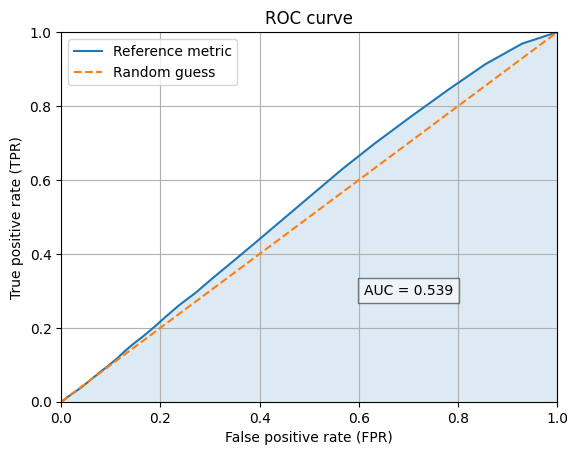

AUC = 0.539


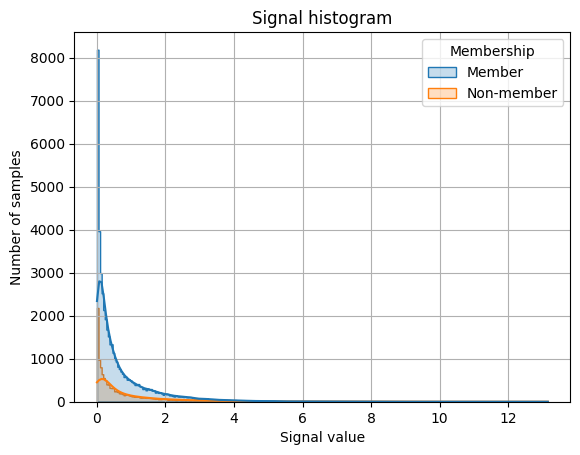

<Figure size 640x480 with 0 Axes>

In [7]:
target_model_S = PytorchModelTensor(model_obj=model_S, loss_fn=criterion, device=device)

# Create information sources
target_info_source_S = InformationSource(
    models=[target_model_S], 
    datasets=[target_dataset]
)

reference_info_source_S = InformationSource(
    models=[target_model_S],
    datasets=[audit_dataset]
)

metric_S = PopulationMetric(
            target_info_source=target_info_source_S,
            reference_info_source=reference_info_source_S,
            signals=[ModelLoss()],
            hypothesis_test_func=linear_itp_threshold_func,
        )

audit_obj_S = Audit(
    metrics=metric_S,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source_S,
    reference_info_sources=reference_info_source_S,
)

audit_obj_S.prepare()

loss_audit_results_S = audit_obj_S.run()[0]


ROCCurveReport.generate_report(
    metric_result=loss_audit_results_S[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

SignalHistogramReport.generate_report(
    metric_result=loss_audit_results_S[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

#### Model Y

Results are stored in: ['/home/clony/Desktop/PrivacyProject_mein/attacks_stacy/log_2024-06-23_21-15-56-000']


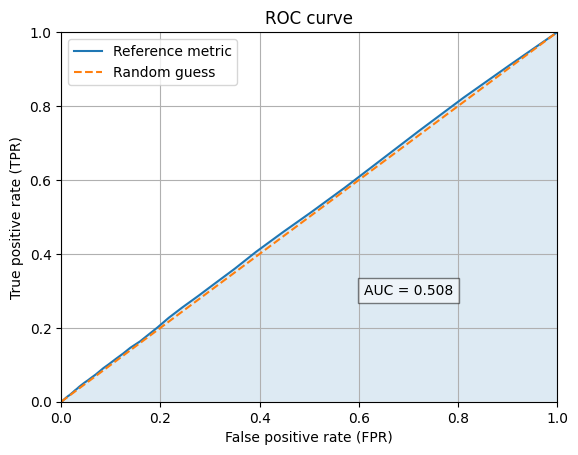

AUC = 0.508


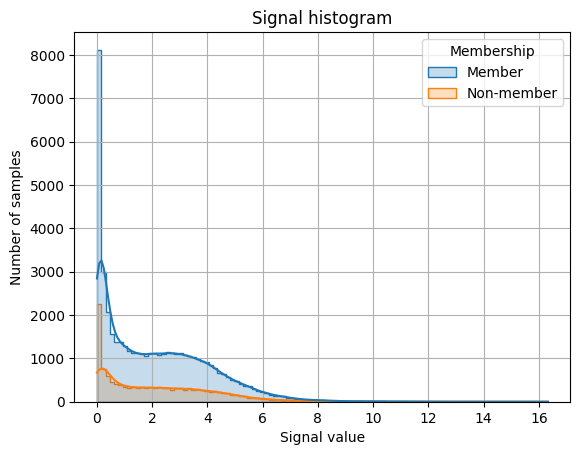

<Figure size 640x480 with 0 Axes>

In [8]:
target_model_Y = PytorchModelTensor(model_obj=model_Y, loss_fn=criterion, device=device)

# Create information sources
target_info_source_Y = InformationSource(
    models=[target_model_Y], 
    datasets=[target_dataset]
)

reference_info_source_Y = InformationSource(
    models=[target_model_Y],
    datasets=[audit_dataset]
)

metric_Y = PopulationMetric(
            target_info_source=target_info_source_Y,
            reference_info_source=reference_info_source_Y,
            signals=[ModelLoss()],
            hypothesis_test_func=linear_itp_threshold_func,
        )

audit_obj_Y = Audit(
    metrics=metric_Y,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source_Y,
    reference_info_sources=reference_info_source_Y,
)

audit_obj_Y.prepare()

loss_audit_results_Y = audit_obj_Y.run()[0]


ROCCurveReport.generate_report(
    metric_result=loss_audit_results_Y[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

SignalHistogramReport.generate_report(
    metric_result=loss_audit_results_Y[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

#### Model X

Results are stored in: ['/home/clony/Desktop/PrivacyProject_mein/attacks_stacy/log_2024-06-23_21-15-59-000']


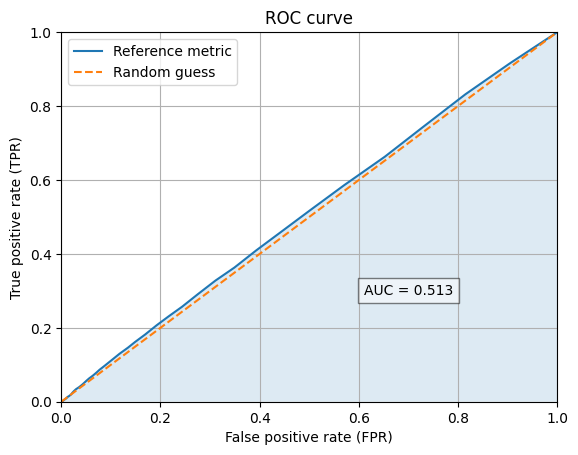

AUC = 0.513


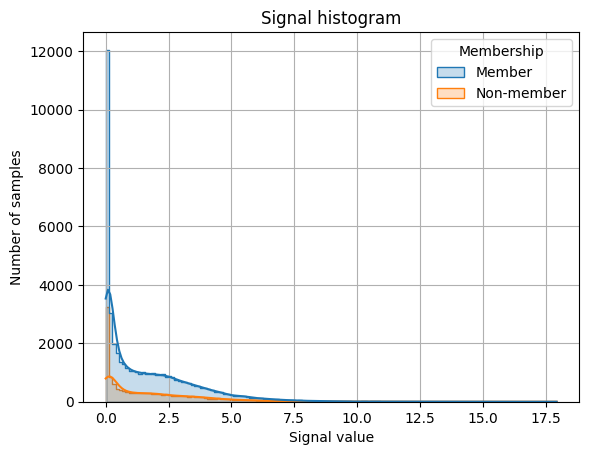

<Figure size 640x480 with 0 Axes>

In [9]:
target_model_X = PytorchModelTensor(model_obj=model_X, loss_fn=criterion, device=device)

# Create information sources
target_info_source_X = InformationSource(
    models=[target_model_X], 
    datasets=[target_dataset]
)

reference_info_source_X = InformationSource(
    models=[target_model_X],
    datasets=[audit_dataset]
)

metric_X = PopulationMetric(
            target_info_source=target_info_source_X,
            reference_info_source=reference_info_source_X,
            signals=[ModelLoss()],
            hypothesis_test_func=linear_itp_threshold_func,
        )

audit_obj_X = Audit(
    metrics=metric_X,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source_X,
    reference_info_sources=reference_info_source_X,
)

audit_obj_X.prepare()

loss_audit_results_X = audit_obj_X.run()[0]


ROCCurveReport.generate_report(
    metric_result=loss_audit_results_X[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

SignalHistogramReport.generate_report(
    metric_result=loss_audit_results_X[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

#### Model E

Results are stored in: ['/home/clony/Desktop/PrivacyProject_mein/attacks_stacy/log_2024-06-23_21-16-01-000']


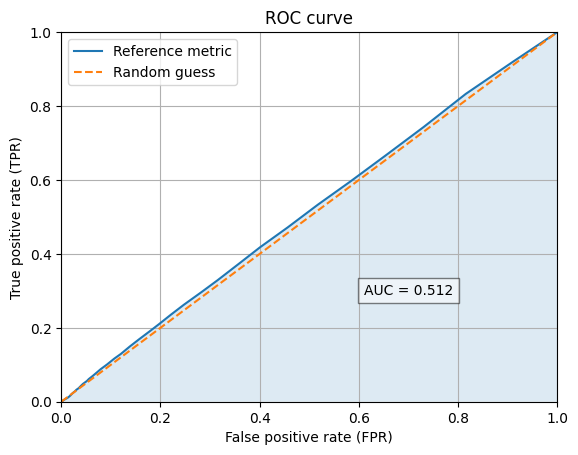

AUC = 0.512


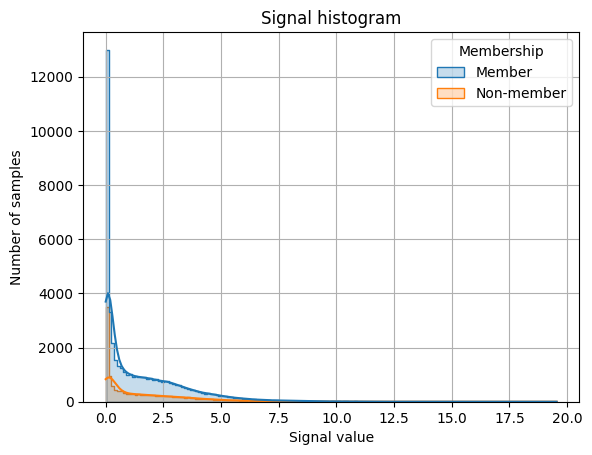

<Figure size 640x480 with 0 Axes>

In [10]:
target_model_E = PytorchModelTensor(model_obj=model_E, loss_fn=criterion, device=device)

# Create information sources
target_info_source_E = InformationSource(
    models=[target_model_E], 
    datasets=[target_dataset]
)

reference_info_source_E = InformationSource(
    models=[target_model_E],
    datasets=[audit_dataset]
)

metric_E = PopulationMetric(
            target_info_source=target_info_source_E,
            reference_info_source=reference_info_source_E,
            signals=[ModelLoss()],
            hypothesis_test_func=linear_itp_threshold_func,
        )

audit_obj_E = Audit(
    metrics=metric_E,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source_E,
    reference_info_sources=reference_info_source_E,
)

audit_obj_E.prepare()

loss_audit_results_E = audit_obj_E.run()[0]


ROCCurveReport.generate_report(
    metric_result=loss_audit_results_E[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

SignalHistogramReport.generate_report(
    metric_result=loss_audit_results_E[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

### Membership Inference Attacks: White box settings

Results are stored in: ['/home/clony/Desktop/PrivacyProject_mein/attacks_stacy/log_2024-06-23_21-16-02-000']


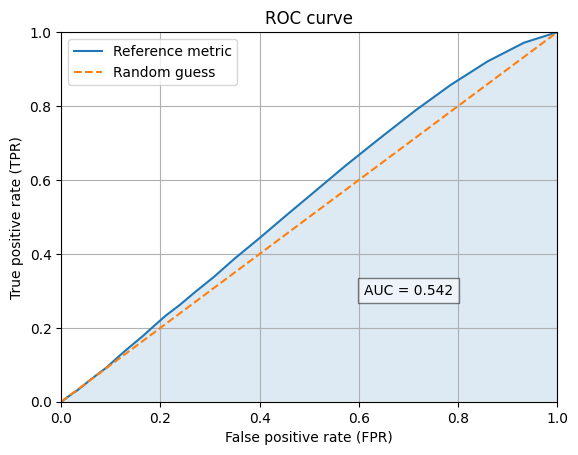

AUC = 0.542


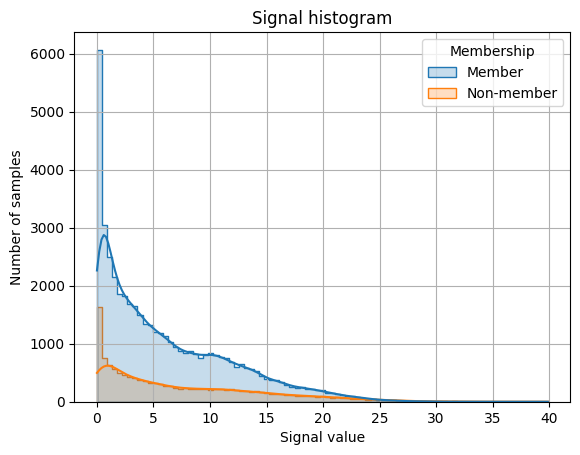

<Figure size 640x480 with 0 Axes>

In [11]:
metric_S = PopulationMetric(
            target_info_source=target_info_source_S,
            reference_info_source=reference_info_source_S,
            signals=[ModelGradientNorm()],
            hypothesis_test_func=linear_itp_threshold_func,
        )

audit_obj_S = Audit(
    metrics=metric_S,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source_S,
    reference_info_sources=reference_info_source_S,
)

audit_obj_S.prepare()

gradient_norm_audit_results_S = audit_obj_S.run()[0]


ROCCurveReport.generate_report(
    metric_result=gradient_norm_audit_results_S[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)


SignalHistogramReport.generate_report(
    metric_result=gradient_norm_audit_results_S[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

Results are stored in: ['/home/clony/Desktop/PrivacyProject_mein/attacks_stacy/log_2024-06-23_21-17-41-000']


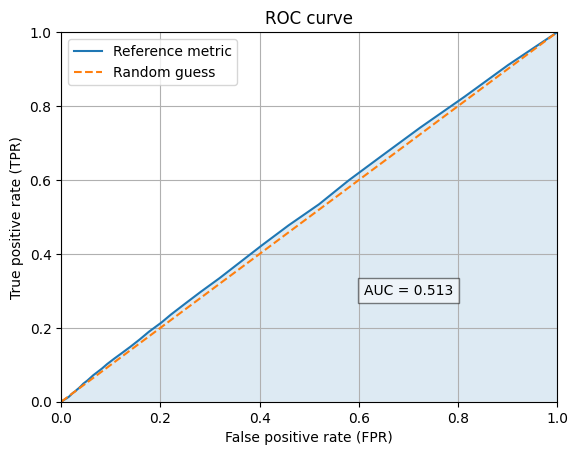

AUC = 0.513


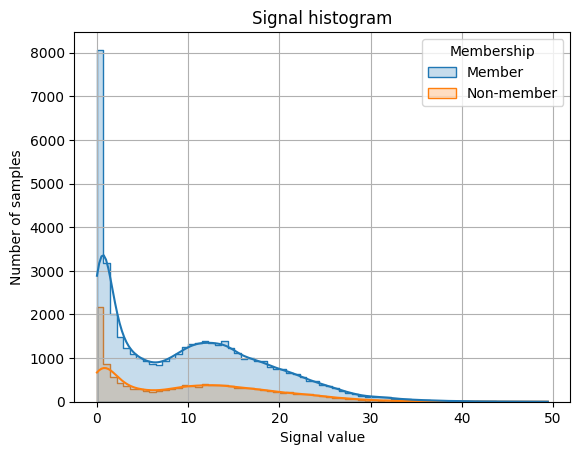

<Figure size 640x480 with 0 Axes>

In [12]:
metric_E = PopulationMetric(
    target_info_source=target_info_source_E,
    reference_info_source=reference_info_source_E,
    signals=[ModelGradientNorm()],
    hypothesis_test_func=linear_itp_threshold_func,
)

audit_obj_E = Audit(
    metrics=metric_E,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source_E,
    reference_info_sources=reference_info_source_E,
)

audit_obj_E.prepare()
gradient_norm_audit_results_E = audit_obj_E.run()[0]

ROCCurveReport.generate_report(
    metric_result=gradient_norm_audit_results_E[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

SignalHistogramReport.generate_report(
    metric_result=gradient_norm_audit_results_E[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)


Results are stored in: ['/home/clony/Desktop/PrivacyProject_mein/attacks_stacy/log_2024-06-23_21-20-10-000']


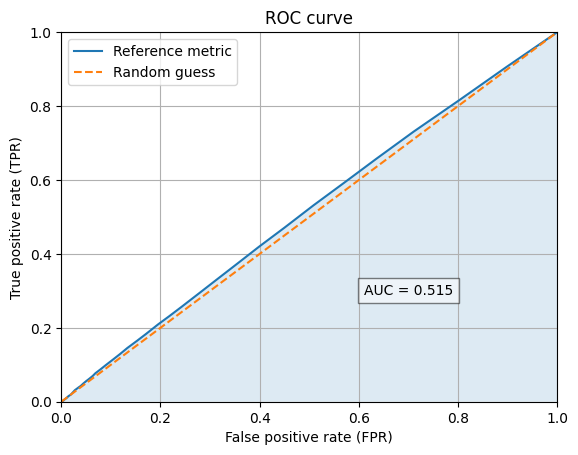

AUC = 0.515


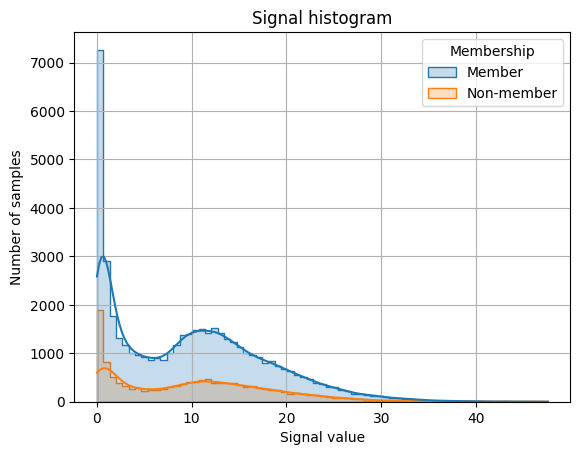

<Figure size 640x480 with 0 Axes>

In [13]:
metric_X = PopulationMetric(
    target_info_source=target_info_source_X,
    reference_info_source=reference_info_source_X,
    signals=[ModelGradientNorm()],
    hypothesis_test_func=linear_itp_threshold_func,
)

audit_obj_X = Audit(
    metrics=metric_X,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source_X,
    reference_info_sources=reference_info_source_X,
)

audit_obj_X.prepare()
gradient_norm_audit_results_X = audit_obj_X.run()[0]

ROCCurveReport.generate_report(
    metric_result=gradient_norm_audit_results_X[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

SignalHistogramReport.generate_report(
    metric_result=gradient_norm_audit_results_X[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

Results are stored in: ['/home/clony/Desktop/PrivacyProject_mein/attacks_stacy/log_2024-06-23_21-22-26-000']


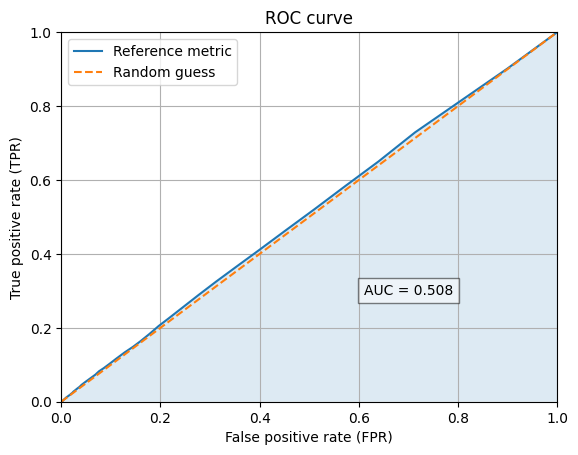

AUC = 0.508


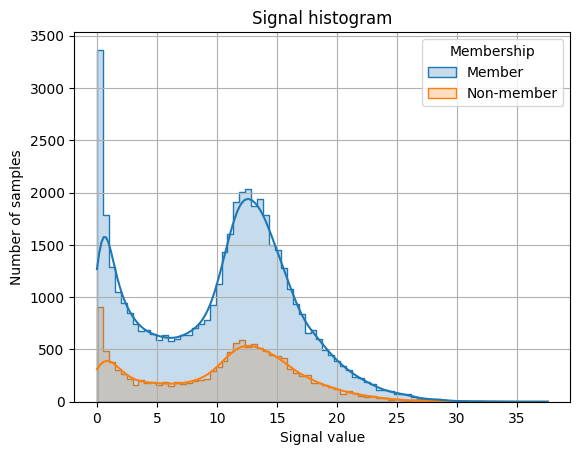

<Figure size 640x480 with 0 Axes>

In [14]:
metric_Y = PopulationMetric(
    target_info_source=target_info_source_Y,
    reference_info_source=reference_info_source_Y,
    signals=[ModelGradientNorm()],
    hypothesis_test_func=linear_itp_threshold_func,
)

audit_obj_Y = Audit(
    metrics=metric_Y,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source_Y,
    reference_info_sources=reference_info_source_Y,
)

audit_obj_Y.prepare()
gradient_norm_audit_results_Y = audit_obj_Y.run()[0]

ROCCurveReport.generate_report(
    metric_result=gradient_norm_audit_results_Y[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

SignalHistogramReport.generate_report(
    metric_result=gradient_norm_audit_results_Y[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)